In [51]:
import pandas as pd
import os
import seaborn as sns
import numpy as np 
import random 
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sqlalchemy import create_engine, text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
%matplotlib inline
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
#maximum number of rows to display
pd.options.display.max_rows = 20
DB_USERNAME = ''
DB_PASSWORD = ''
DB_HOST = ''
DB_PORT= ''
DB_NAME = ''
engine=create_engine(f'postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}', max_overflow=20, client_encoding='utf8')

def runQuery(sql):
    result = engine.connect().execution_options(isolation_level="AUTOCOMMIT").execute((text(sql)))
    return pd.DataFrame(result.fetchall(), columns=result.keys())

In [4]:
query1="""
select * from ecar_dwh.ecar_dwh_base_modelo """
df1=runQuery(query1)

# EDA

In [4]:
cols_num=['calls', 'total', 'espera', 'hablado', 'disponible', 'pausas',
       'muerto', 'duracion_efectivas', 'dias_trabajados',
       'efectivas_Mujer', 'efectivas_Hombre', 'efectivas_Alto',
       'efectivas_Medio_Alto', 'efectivas_Medio_Medio', 'efectivas_Bajo',
       'efectivas_Medio_Bajo', 'efectivas_Tunja', 'efectivas_Popayán',
       'efectivas_Montería', 'efectivas_Manizales', 'efectivas_Armenia',
       'efectivas_Villavicencio', 'efectivas_Pasto', 'efectivas_Cúcuta',
       'efectivas_Santa Marta', 'efectivas_Ibagué', 'efectivas_Neiva',
       'efectivas_Pereira', 'efectivas_Cartagena', 'efectivas_Cali',
       'efectivas_Bucaramanga', 'efectivas_Barranquilla', 'efectivas_Medellín',
       'efectivas_Bogotá', 'efectivas_rango_edad_5', 'efectivas_rango_edad_2',
       'efectivas_rango_edad_4', 'efectivas_rango_edad_3',
       'efectivas_rango_edad_1', 'meses_trabajados','competencias_funcionales', 'numeros', 
       'lectura_voz_alta','fluidez_lectura', 'cartografia', 'competencias_organizacionales',
       'sumar', 'coherencia_entre_numeros']
cols_cat=['como_conocio_cnc','localidad', 'educacion_formal', 'estado_educacion',
       'nombre_educacion']

## The business problem is identify the main causes of difference in productivity across the pollsters, for that reason we want to pronostique the efective calls by pollsters according to relationship between the other variables

## we have some issues with this data 

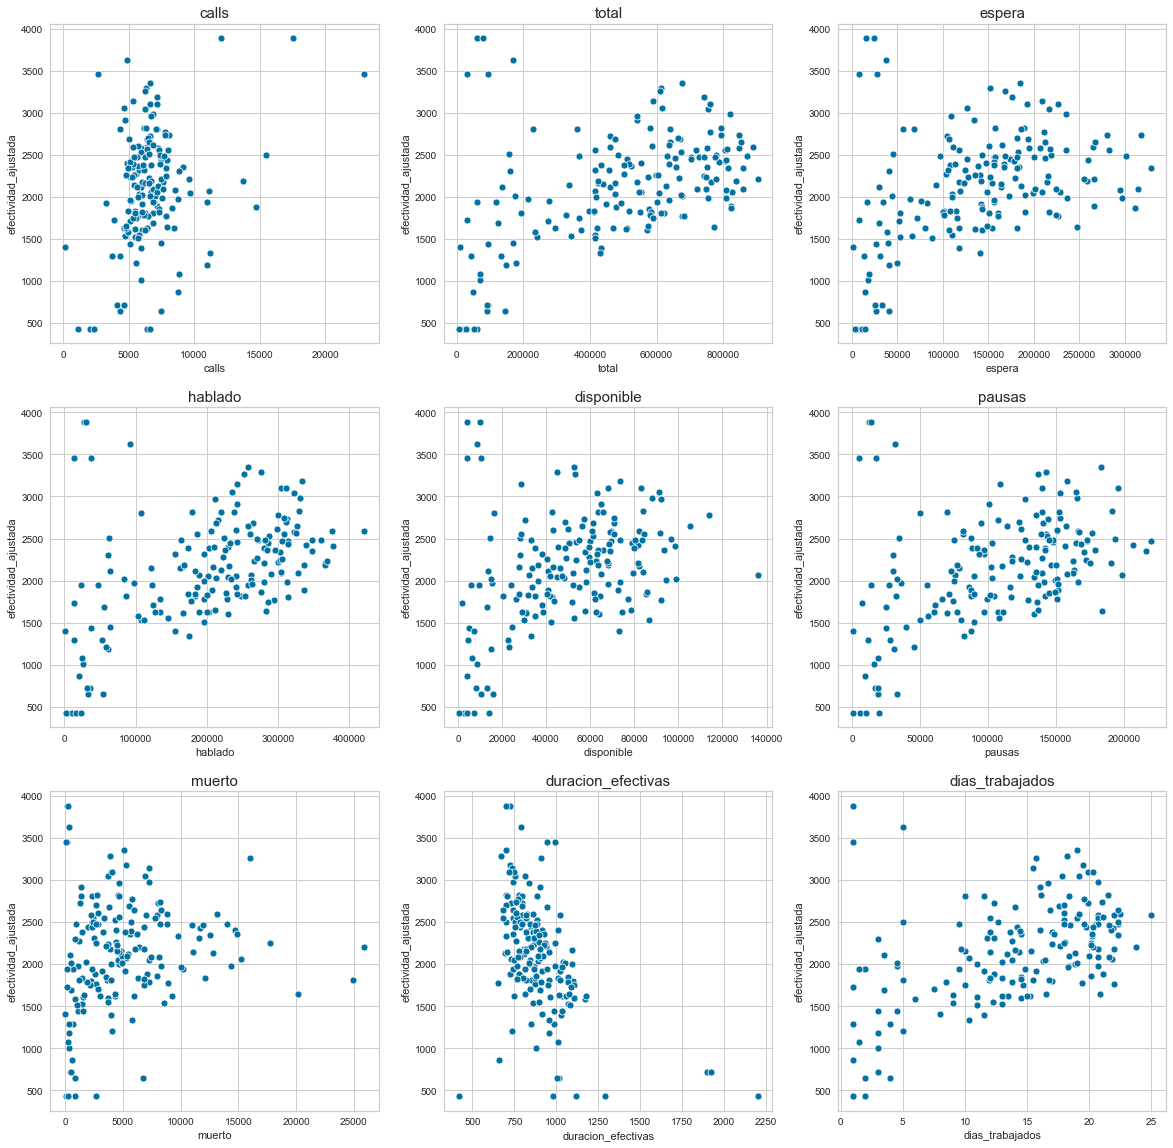

In [5]:
fig, ax = plt.subplots(ncols=3, nrows=3,figsize=(20,20))
for col, axis in zip(cols_num, ax.flatten()):        
    ax_ = sns.scatterplot(x=col,y='efectividad_ajustada', data=df1, ax=axis)
    axis.set_title(col, fontsize=15)

In [6]:
df1.groupby('como_conocio_cnc')['codenc'].count()

df1['como_conocio_cnc'].replace({'internet - zonajobs.com': 'internet - computrabajo.com',
                        'periodico - adn':'otros' ,'periodico - el tiempo':'otros'}, inplace=True)


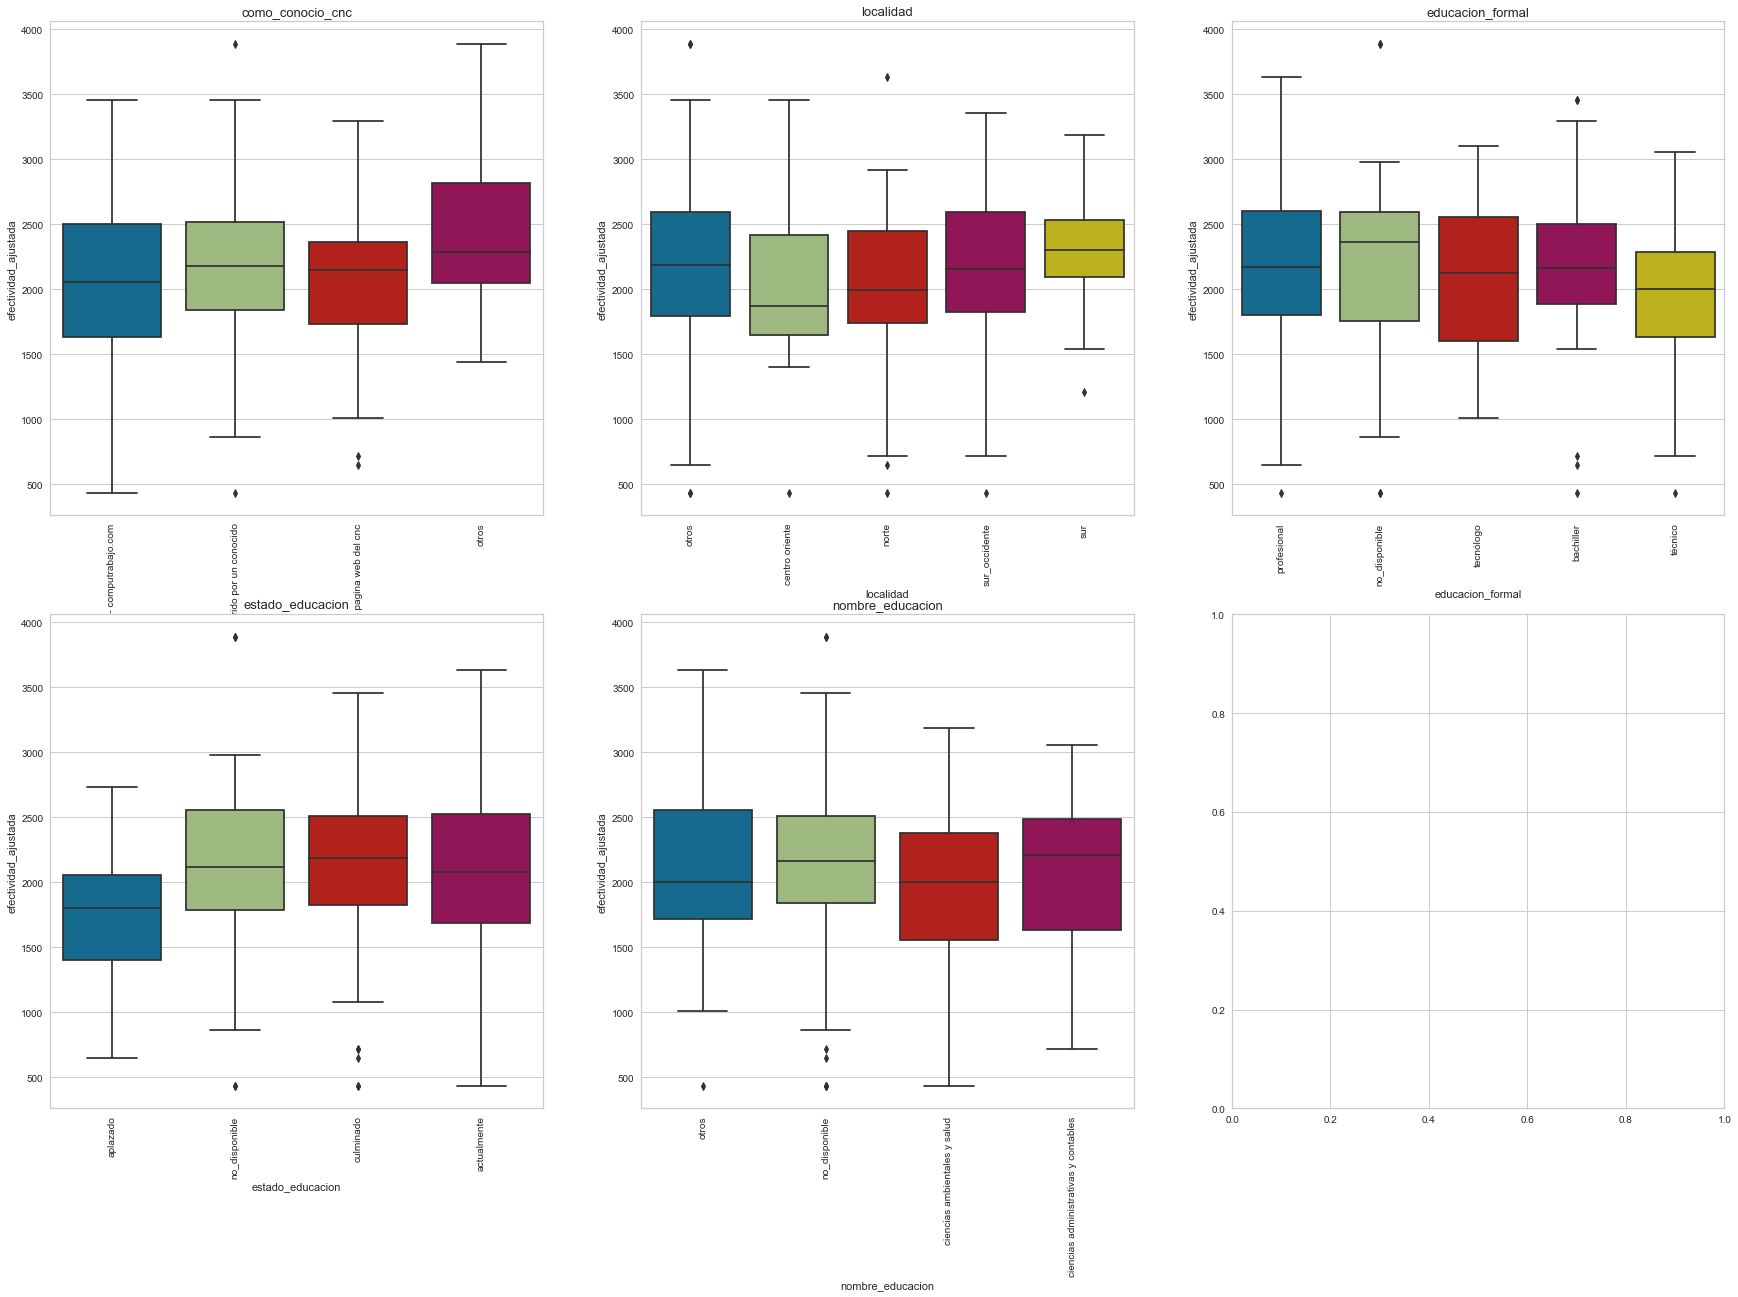

In [7]:
fig, ax = plt.subplots(ncols=3, nrows=2,figsize=(30,20))
for col, axis in zip(cols_cat, ax.flatten()):        
    ax_ = sns.boxplot(x=col,y='efectividad_ajustada',  data=df1, ax=axis)
    axis.set_title(col, fontsize=13) 
    axis.tick_params(axis="x",rotation=90, labelsize=10)

In [5]:
df_dummies=pd.get_dummies(df1.drop(['codenc','total'],  axis=1),
            columns=['como_conocio_cnc','localidad', 'educacion_formal', 'estado_educacion','nombre_educacion'])

df_dummies.columns= df_dummies.columns.str.replace(' ','_',regex=True)
df_dummies.columns= df_dummies.columns.str.replace('-_', '',regex=True)
df_dummies.columns= df_dummies.columns.str.replace('.', '_',regex=True)

In [9]:
q1=df1['efectividad_ajustada'].quantile(q=0.33)
q2=df1['efectividad_ajustada'].quantile(q=0.66)

In [10]:
df_dummies['efectividad']=' '
df_dummies.loc[df_dummies['efectividad_ajustada']<q1, ['efectividad']]='efectividad_baja'
df_dummies.loc[((df_dummies['efectividad_ajustada']>=q1)&(df_dummies['efectividad_ajustada']<q2)), ['efectividad']]='efectividad_media'
df_dummies.loc[df_dummies['efectividad_ajustada']>=q2, ['efectividad']]='efectividad_alta'

In [11]:
df_dummies.groupby('efectividad').count()

calls  espera  hablado  disponible  pausas  muerto  \
efectividad                                                             
efectividad_alta      59      59       59          59      59      59   
efectividad_baja      57      57       57          57      57      57   
efectividad_media     56      56       56          56      56      56   

                   duracion_efectivas  dias_trabajados  efectividad_ajustada  \
efectividad                                                                    
efectividad_alta                   59               59                    59   
efectividad_baja                   57               57                    57   
efectividad_media                  56               56                    56   

                   efectivas_mujer  ...  educacion_formal_tecnólogo  \
efectividad                         ...                               
efectividad_alta                59  ...                          59   
efectividad_baja                57  ...                          57   
efectividad_media               56  ...                          56   

                   educacion_formal_técnico  estado_educacion_actualmente  \
efectividad                                                                 
efectividad_alta                         59                            59   
efectividad_baja                         57                            57   
efectividad_media                        56                            56   

                   estado_educacion_aplazado  estado_educacion_culminado  \
efectividad                                                                
efectividad_alta                          59                          59   
efectividad_baja                          57                          57   
efectividad_media                         56                          56   

                   estado_educacion_no_disponible  \
efectividad                                         
efectividad_alta                               59   
efectividad_baja                               57   
efectividad_media                              56   

                   nombre_educacion_ciencias_administrativas_y_contables  \
efectividad                                                                
efectividad_alta                                                  59       
efectividad_baja                                                  57       
efectividad_media                                                 56       

                   nombre_educacion_ciencias_ambientales_y_salud  \
efectividad                                                        
efectividad_alta                                              59   
efectividad_baja                                              57   
efectividad_media                                             56   

                   nombre_educacion_no_disponible  nombre_educacion_otros  
efectividad                                                                
efectividad_alta                               59                      59  
efectividad_baja                               57                      57  
efectividad_media                              56                      56  

[3 rows x 70 columns]

In [12]:
df_dummies['efectividad'].replace({'efectividad_baja':0, 'efectividad_media':1, 'efectividad_alta':2}, inplace=True)

# DESCRIPTIVE MODEL

# REGRESSION MODEL

## 1. WE WILL FIT A REGRESSION LINEAL MODEL WITH ALL VARIABLES

In [13]:
def regression_lineal(df, cols):
    reg_formula = 'efectividad_ajustada ~ ' + ' + '.join(col for col in cols)
    model = smf.ols(formula = reg_formula, data = df).fit()
    summary=model.summary()
    return summary 


def examine_multicolineality(df, cols): 
    plt.imshow(
        df[cols].corr(), # the correlation matrix
        vmin=-1,       # minimum value for the colorbar
        vmax=1,        # maximum value for the colorbar
        cmap='RdYlBu', # color scheme
    )
    plt.grid(False)

    # label the axes:
    plt.xticks(range(len(cols)), labels=cols, rotation=90)
    plt.yticks(range(len(cols)), labels=cols)
    plt.colorbar()

In [14]:
covariates=df_dummies.columns.tolist()[:7]+df_dummies.columns.tolist()[9:70]
summary_model_all=regression_lineal(df_dummies, covariates)
summary_model_all

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     efectividad_ajustada   R-squared:                       0.919
Model:                              OLS   Adj. R-squared:                  0.875
Method:                   Least Squares   F-statistic:                     20.96
Date:                  Sun, 19 Jul 2020   Prob (F-statistic):           9.33e-40
Time:                          14:19:45   Log-Likelihood:                -1142.9
No. Observations:                   172   AIC:                             2408.
Df Residuals:                       111   BIC:                             2600.
Df Model:                            60                                         
Covariance Type:              nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                               233.3215    121.106      1.927      0.057      -6.658     473.301
calls                                                     0.0194      0.012      1.626      0.107      -0.004       0.043
espera                                                   -0.0018      0.001     -2.899      0.005      -0.003      -0.001
hablado                                                   0.0012      0.001      2.018      0.046    2.21e-05       0.002
disponible                                               -0.0012      0.001     -0.827      0.410      -0.004       0.002
pausas                                                    0.0025      0.002      1.623      0.108      -0.001       0.006
muerto                                                   -0.0134      0.006     -2.059      0.042      -0.026      -0.001
duracion_efectivas                                       -0.4190      0.145     -2.890      0.005      -0.706      -0.132
efectivas_mujer                                           0.2675      0.107      2.492      0.014       0.055       0.480
efectivas_hombre                                          0.3279      0.102      3.216      0.002       0.126       0.530
efectivas_alto                                           -0.2346      0.258     -0.911      0.365      -0.745       0.276
efectivas_medio_alto                                      0.4580      0.264      1.738      0.085      -0.064       0.980
efectivas_medio_medio                                    -0.2780      0.244     -1.141      0.256      -0.761       0.205
efectivas_bajo                                            0.3339      0.129      2.588      0.011       0.078       0.590
efectivas_medio_bajo                                      0.3160      0.162      1.953      0.053      -0.005       0.637
efectivas_tunja                                          -0.2548      0.589     -0.432      0.666      -1.422       0.913
efectivas_popayán                                        -0.2557      0.701     -0.365      0.716      -1.646       1.134
efectivas_montería                                        0.7801      0.750      1.041      0.300      -0.705       2.266
efectivas_manizales                                      -0.6298      0.566     -1.113      0.268      -1.751       0.491
efectivas_armenia                                         1.1082      0.803      1.380      0.170      -0.483       2.699
efectivas_villavicencio                                  -0.6579      0.684     -0.961      0.339      -2.014       0.698
efectivas_pasto                                          -0.0903      0.824     -0.110      0.913      -1.723       1.542
efectivas_c

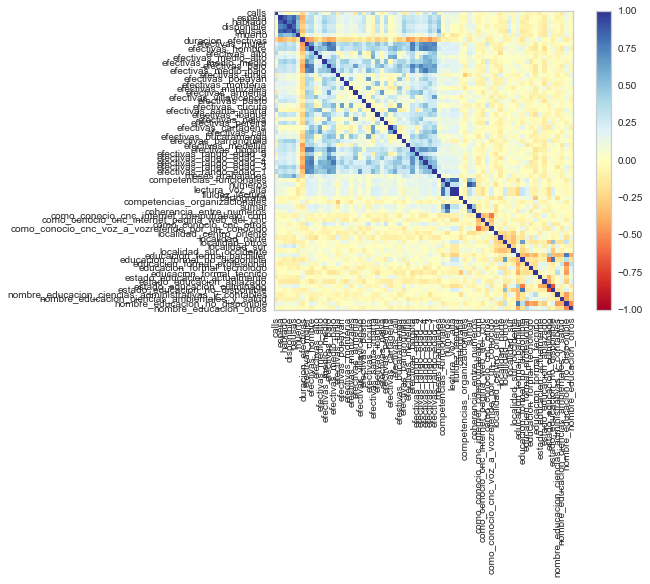

In [15]:
examine_multicolineality(df_dummies, covariates)

## 2. WE WILL FIT A LINEAR A REGRESSION MODEL WITH ONLY SIGNIFICANT VARIABLES

In [16]:
cols_sig=['calls', 'duracion_efectivas','muerto','pausas', 
       'como_conocio_cnc_internet_computrabajo_com','como_conocio_cnc_internet_pagina_web_del_cnc',
       'como_conocio_cnc_otros','como_conocio_cnc_voz_a_vozreferido_por_un_conocido',
       'localidad_centro_oriente', 'localidad_norte', 'localidad_otros','localidad_sur', 'localidad_sur_occidente',
        'estado_educacion_actualmente', 'estado_educacion_aplazado', 'estado_educacion_culminado', 'estado_educacion_no_disponible']

summary_model_sig=regression_lineal(df_dummies, cols_sig)
summary_model_sig


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     efectividad_ajustada   R-squared:                       0.446
Model:                              OLS   Adj. R-squared:                  0.397
Method:                   Least Squares   F-statistic:                     9.034
Date:                  Sun, 19 Jul 2020   Prob (F-statistic):           2.63e-14
Time:                          14:19:56   Log-Likelihood:                -1308.1
No. Observations:                   172   AIC:                             2646.
Df Residuals:                       157   BIC:                             2693.
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                           1332.9091    170.270      7.828      0.000     996.594    1669.224
calls                                                  0.0574      0.016      3.494      0.001       0.025       0.090
duracion_efectivas                                    -1.1079      0.224     -4.950      0.000      -1.550      -0.666
muerto                                                -0.0299      0.011     -2.619      0.010      -0.052      -0.007
pausas                                                 0.0057      0.001      5.684      0.000       0.004       0.008
como_conocio_cnc_internet_computrabajo_com           277.8028     77.812      3.570      0.000     124.109     431.496
como_conocio_cnc_internet_pagina_web_del_cnc         286.6298     95.992      2.986      0.003      97.028     476.232
como_conocio_cnc_otros                               493.2829    101.320      4.869      0.000     293.157     693.409
como_conocio_cnc_voz_a_vozreferido_por_un_conocido   275.1935     78.170      3.520      0.001     120.793     429.594
localidad_centro_oriente                             133.7742     99.241      1.348      0.180     -62.245     329.793
localidad_norte                                      294.9186     82.378      3.580      0.000     132.207     457.631
localidad_otros                                      373.8598     91.639      4.080      0.000     192.855     554.864
localidad_sur                                        193.2223    104.397      1.851      0.066     -12.981     399.425
localidad_sur_occidente                              337.1342     81.663      4.128      0.000     175.834     498.434
estado_educacion_actualmente                         518.2217    147.357      3.517      0.001     227.165     809.279
estado_educacion_aplazado                            122.4174    128.588      0.952      0.343    -131.569     376.403
estado_educacion_culminado                           394.3356     79.871      4.937      0.000     236.575     552.096
estado_educacion_no_disponible                       297.9344    106.776      2.790      0.006      87.032     508.837
==============================================================================
Omnibus:                       17.527   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.219
Skew:                           0.436   Prob(JB):                     8.28e-09
Kurtosis:                       5.105   Cond. No.                     1.04e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correc

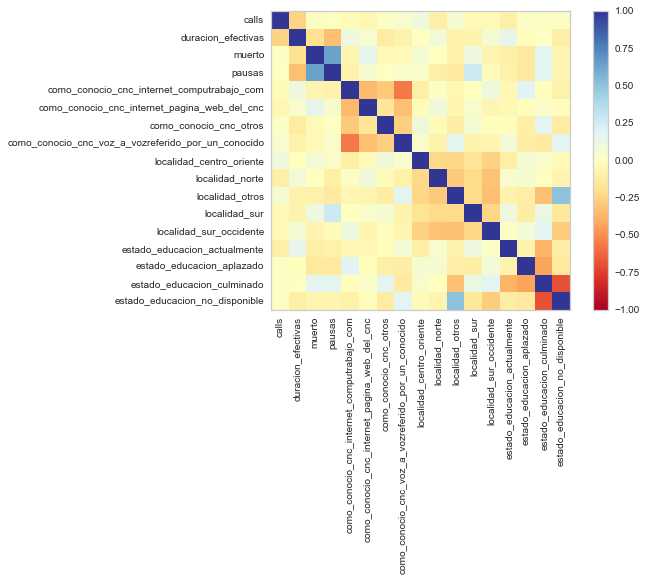

In [17]:
examine_multicolineality(df_dummies, cols_sig)

# PREDICTIVE MODELS 

# DECISION TREES

## 1. WE WILL TRAIN A DECISION TREE MODELL WITH ALL VARIABLES

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies[covariates], df_dummies['efectividad'], test_size=0.4, random_state=11) # 70% training and 30% test

In [19]:
def train_decisionTree(X_train,y_train, X_test):
    model=tree.DecisionTreeClassifier(max_depth=100, 
                                  random_state=0)
    model=model.fit(X_train,y_train)
    pscore_decision=model.predict(X_test)
    return pscore_decision, model

def plot_decisionTree(model, cols):
    fig = plt.gcf()
    fig.set_size_inches(150, 100)
    tree.plot_tree(model,filled=True,feature_names=cols)
    fig.savefig('tree.png')
    
    
def evaluate_model(model, y_test,pscore_decision, cols, num):
    print(confusion_matrix(y_test,pscore_decision))
    print(f"Accuracy in  dataset: {accuracy_score(y_test,pscore_decision)}")
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [cols[i] for i in indices]
    datos_importances=pd.DataFrame({'covar': names, 'coef': importances[indices]})
    sns.barplot(y='covar', x='coef', data=datos_importances.head(num))

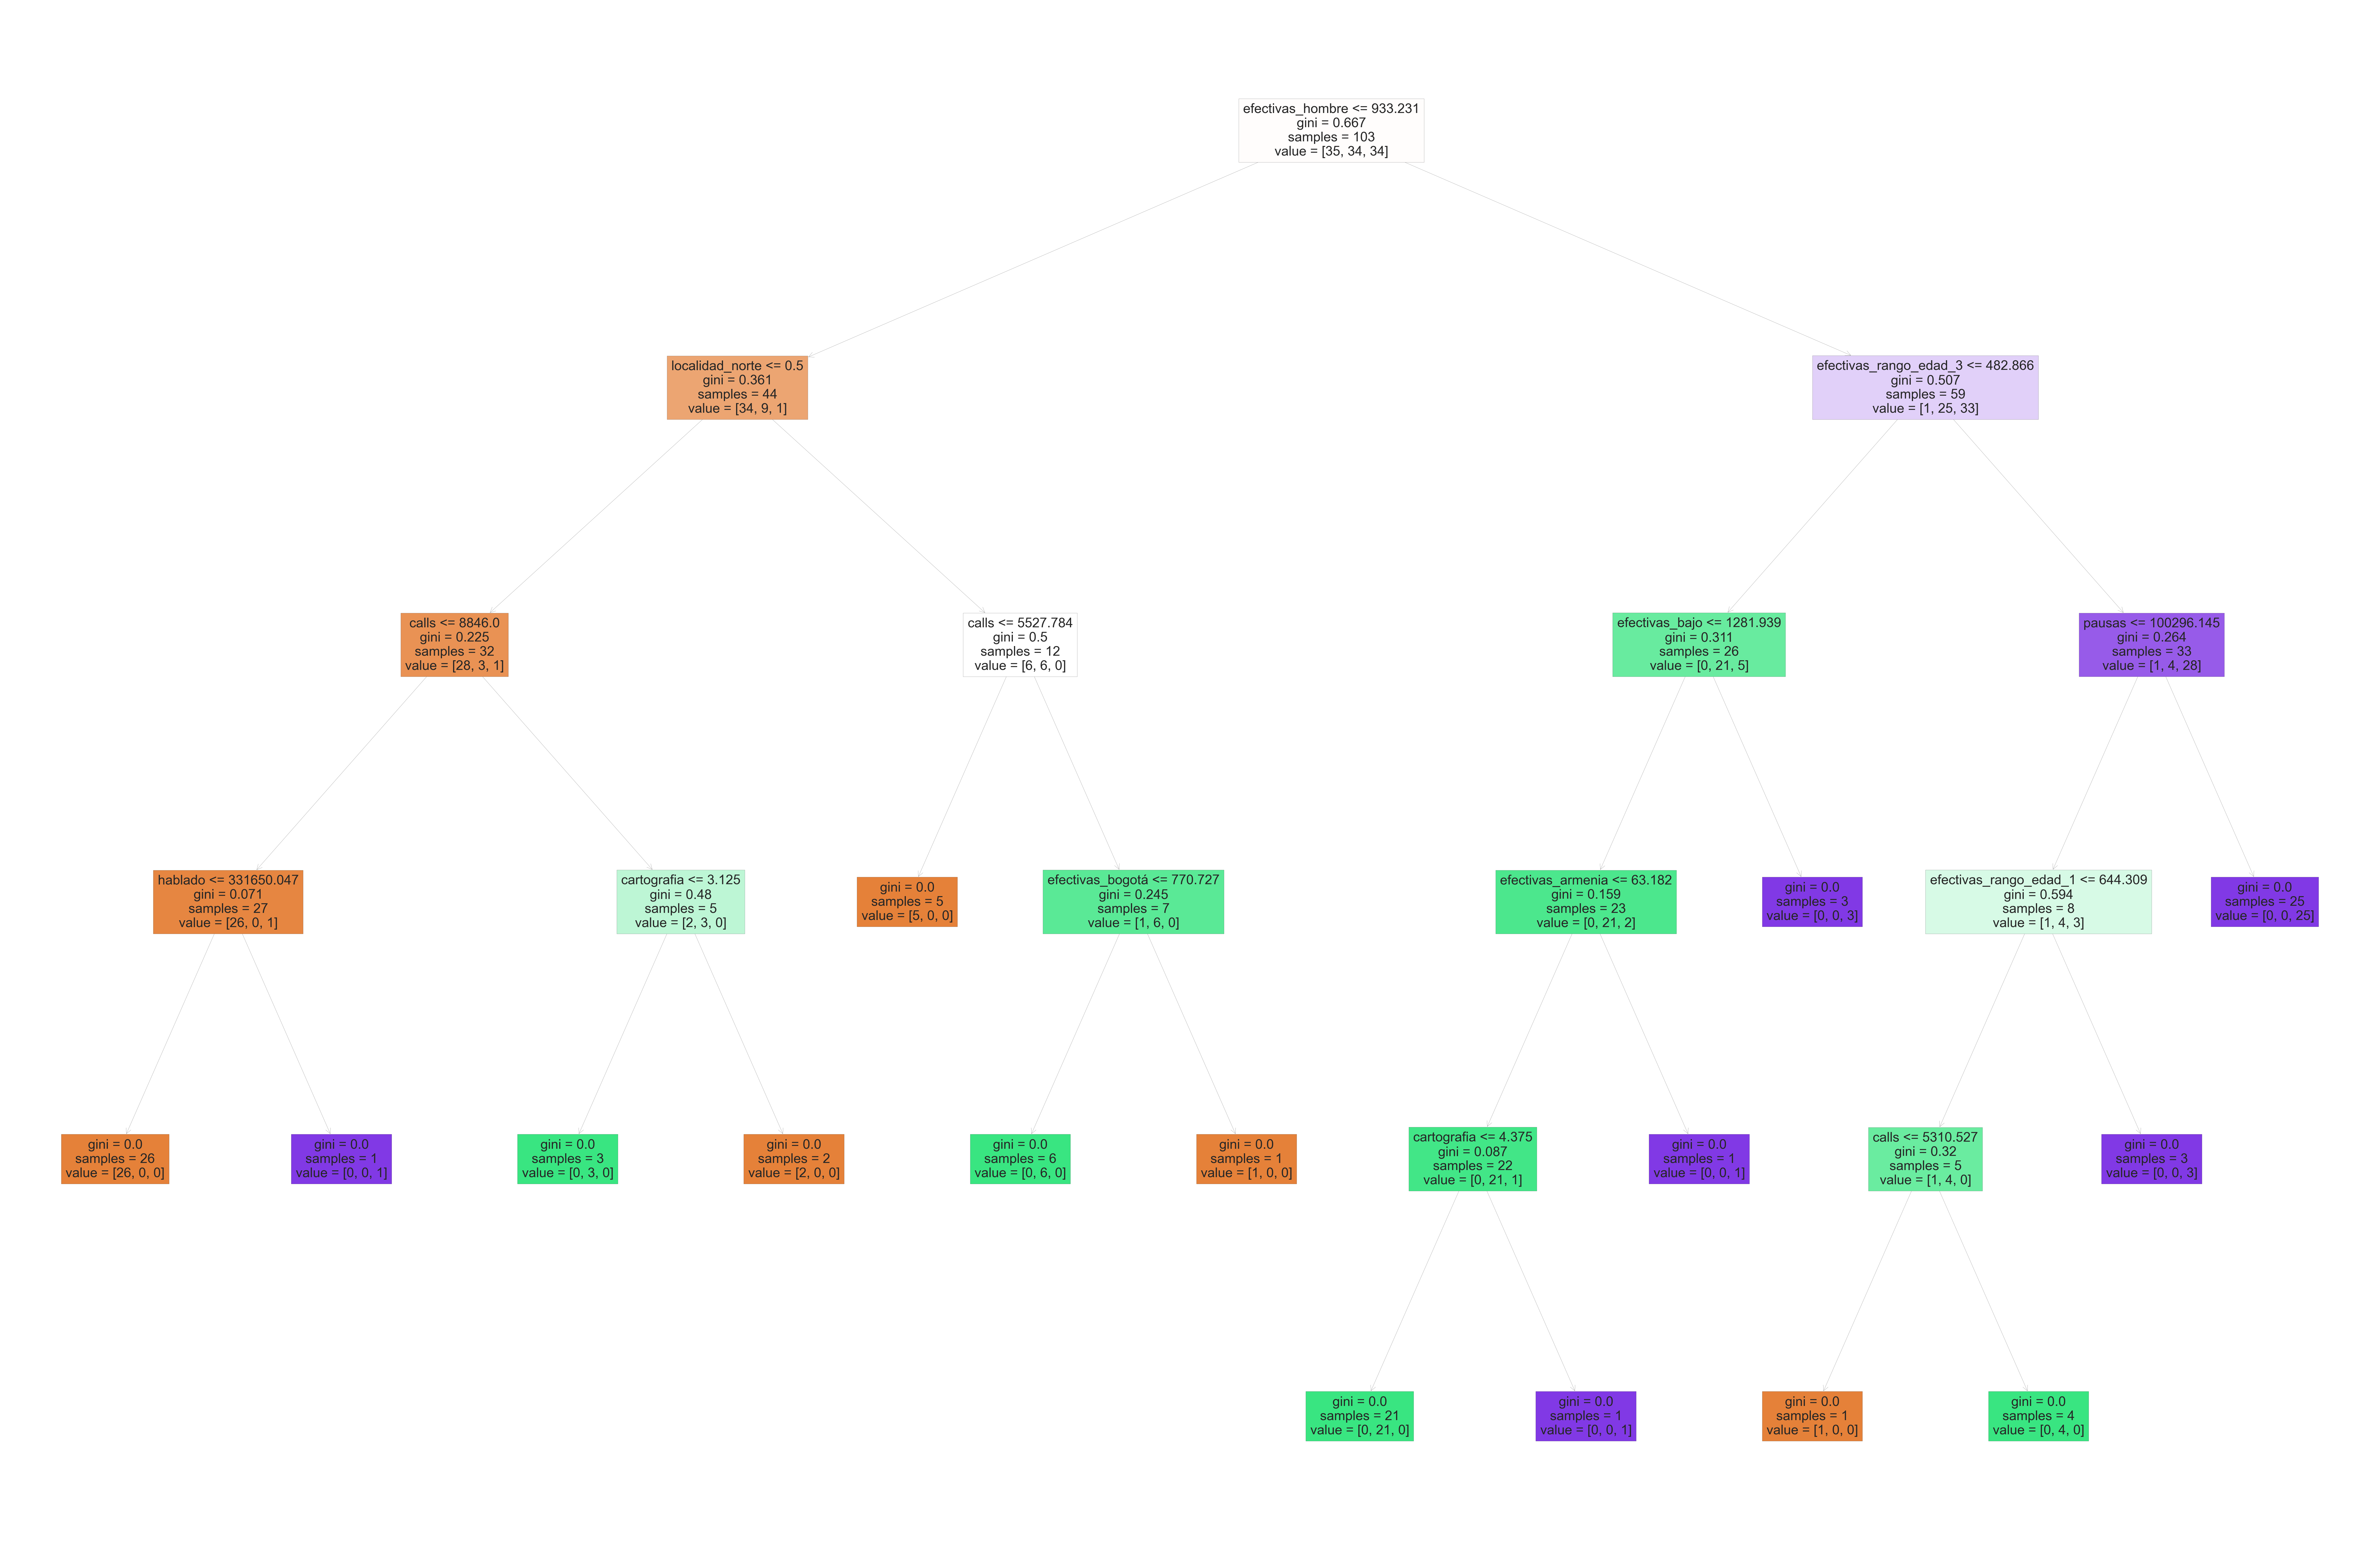

In [20]:
pscore_decision, model_decision=train_decisionTree(X_train,y_train, X_test)
plot_decisionTree(model_decision, covariates)


[[17  5  0]
 [ 9 10  3]
 [ 1  5 19]]
Accuracy in  dataset: 0.6666666666666666


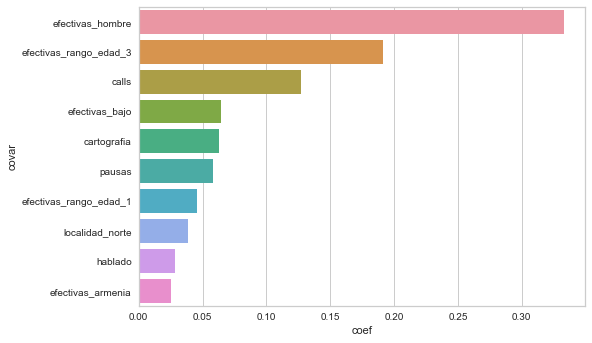

In [21]:
evaluate_model(model_decision, y_test,pscore_decision, covariates, 10)

## 2. WE WILL TRAIN A TREE DECISION MODEL ONLY WITH THE SIGNIFICANT VARIABLES ACCORDING TO LINEAR REGRESSION

In [22]:
X_train_sig=X_train[cols_sig]
X_test_sig=X_test[cols_sig]

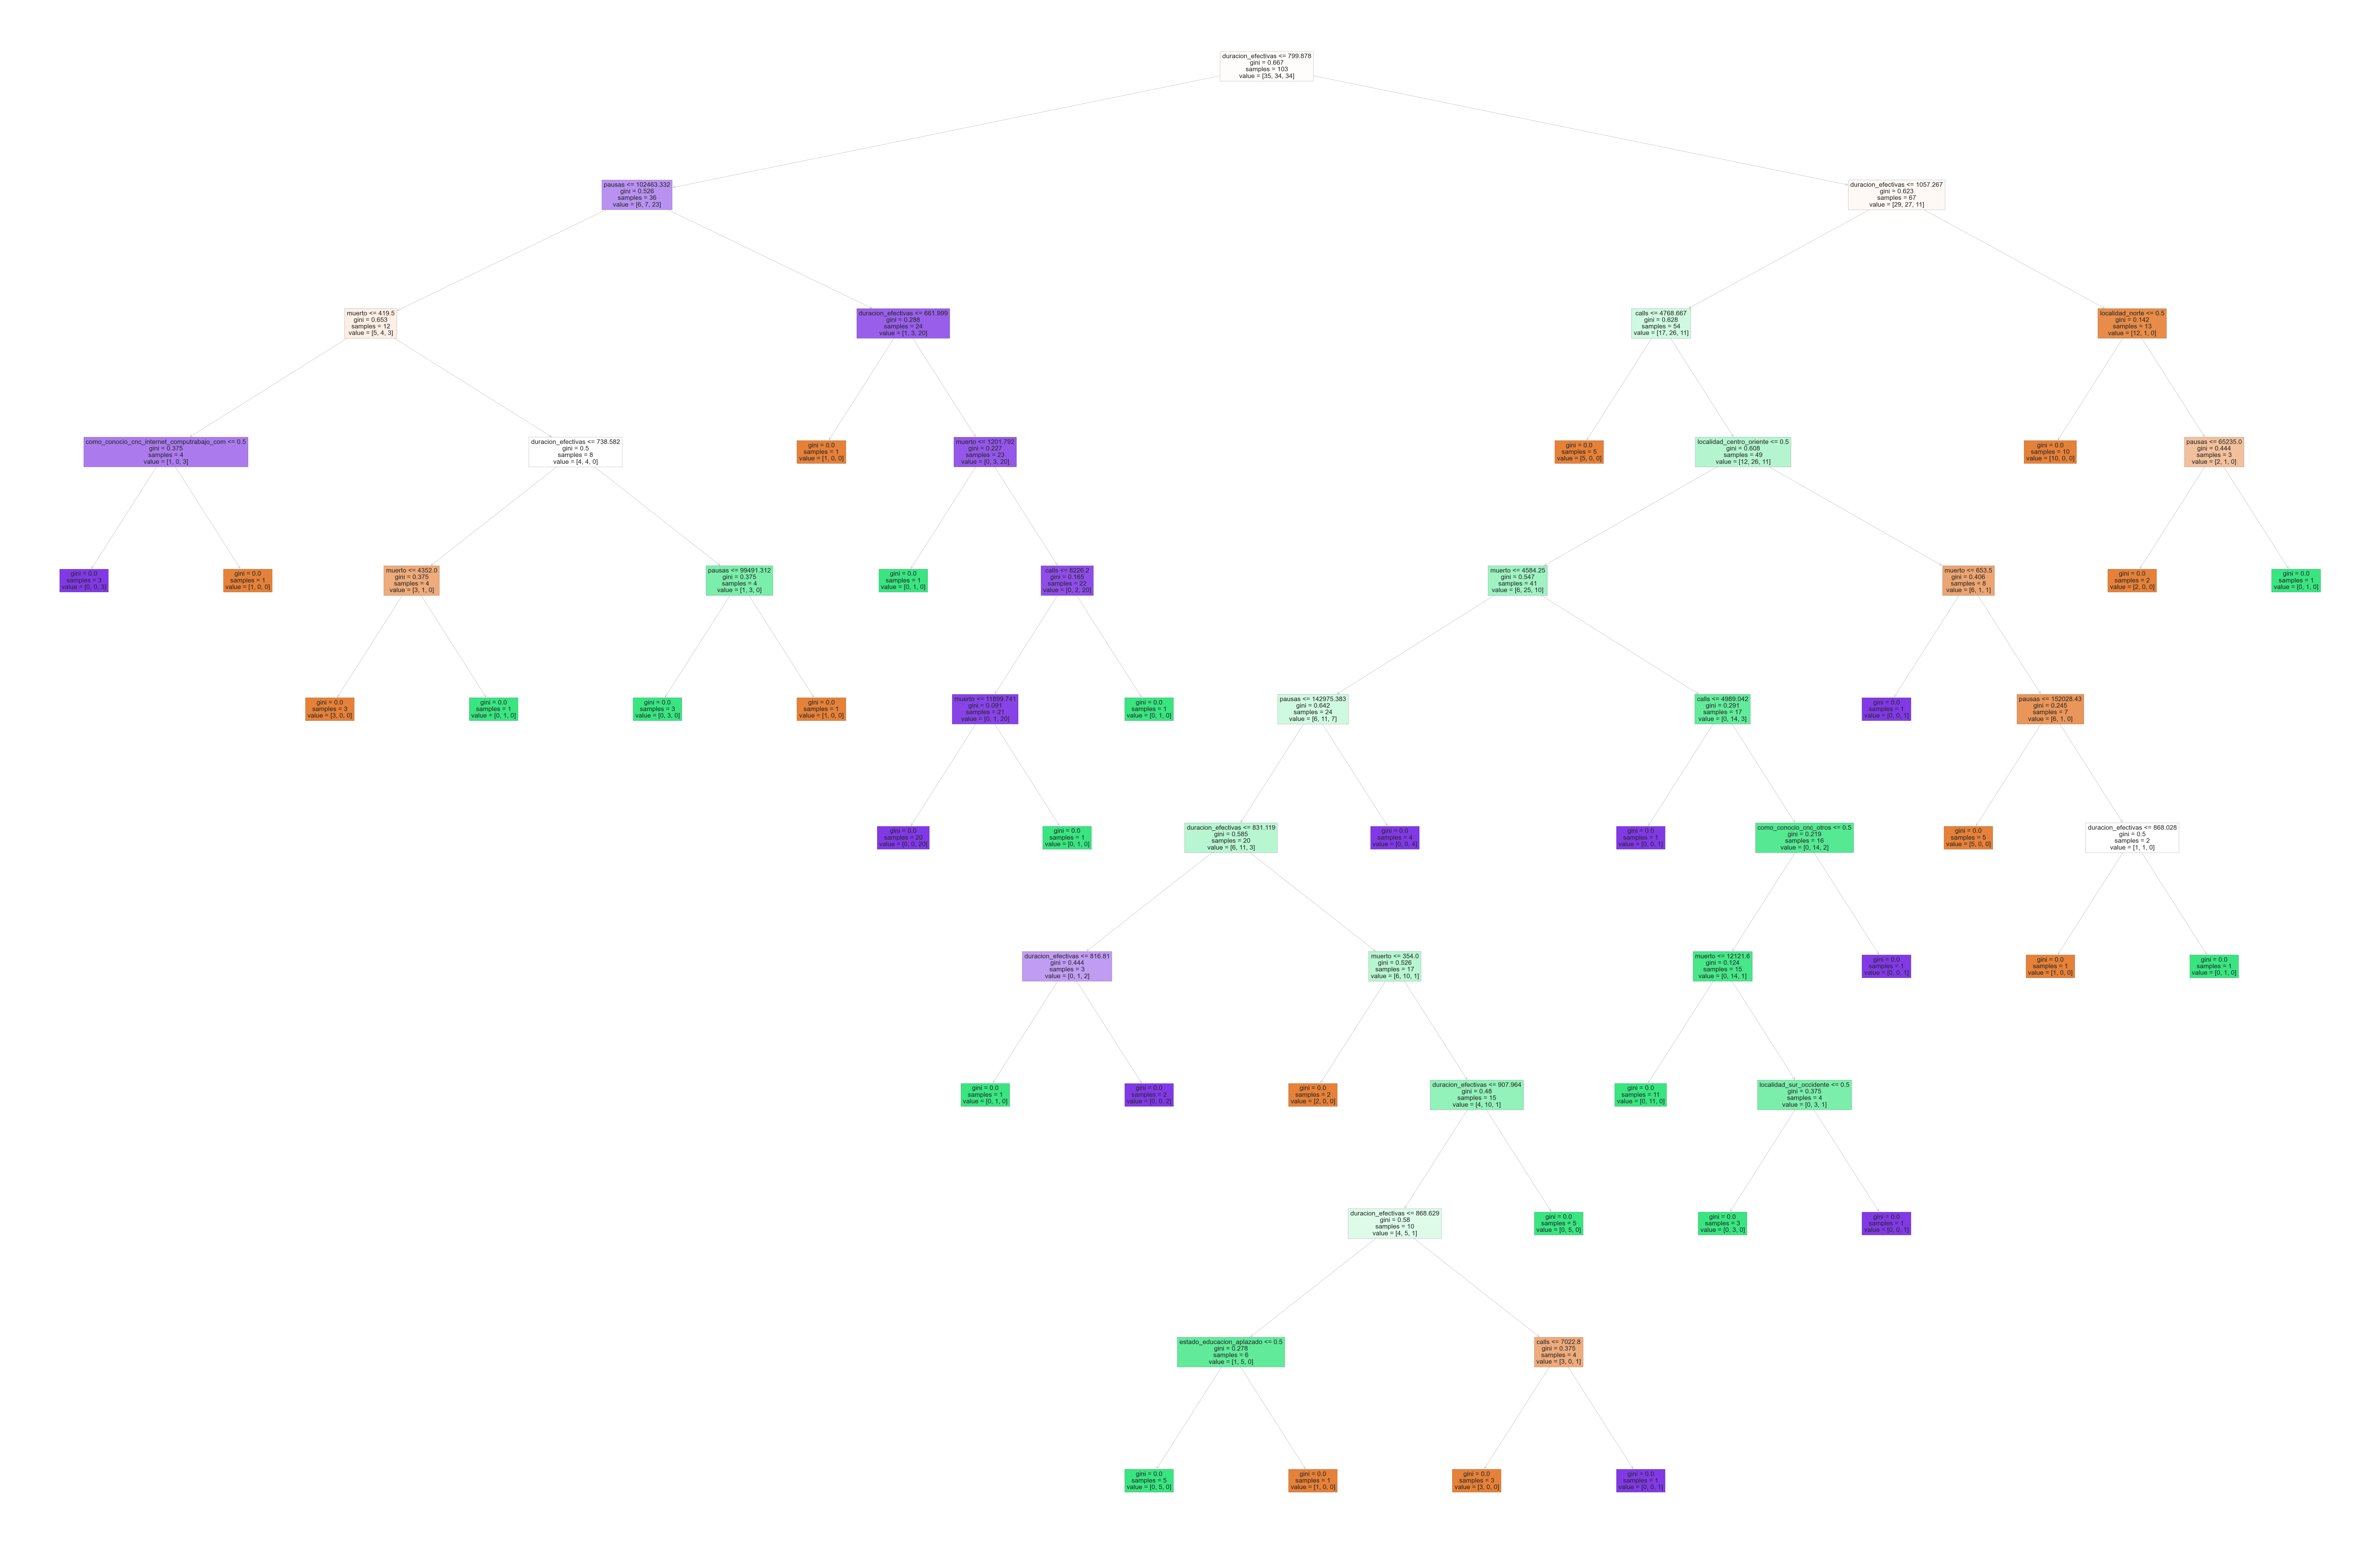

In [23]:
pscore_decision2, model_decision2=train_decisionTree(X_train_sig,y_train, X_test_sig)
plot_decisionTree(model_decision2, cols_sig)

[[10 10  2]
 [ 5 10  7]
 [ 6 10  9]]
Accuracy in  dataset: 0.42028985507246375


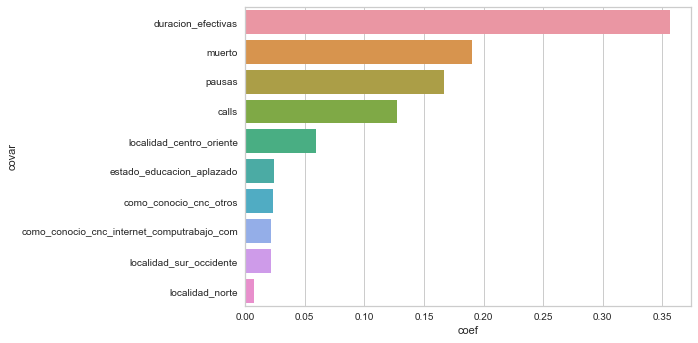

In [24]:
evaluate_model(model_decision2, y_test,pscore_decision2, cols_sig, 10)

# RANDOM FOREST

## 1. WE WILL TRAIN A DECISION TREE MODELL WITH ALL VARIABLES

In [25]:
def train_random_forest(X_train,y_train,n,X_test):
    clf=RandomForestClassifier(n_estimators=n, random_state=20)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    return y_pred, clf

In [26]:
ps_score_forest, model_random=train_random_forest(X_train,y_train,200,X_test)

[[21  1  0]
 [ 3 17  2]
 [ 1  3 21]]
Accuracy in  dataset: 0.855072463768116


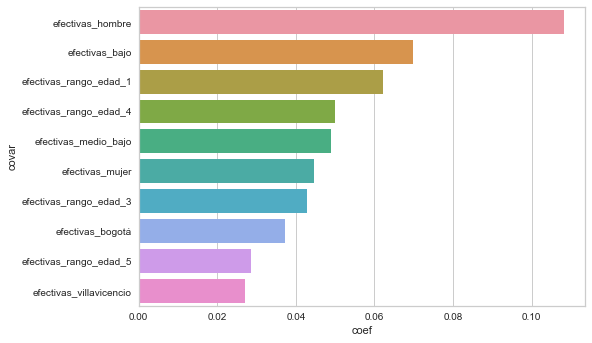

In [27]:
evaluate_model(model_random,y_test,ps_score_forest,covariates,10)

## 2. WE WILL TRAIN A RANDOM FOREST MODEL ONLY WITH THE SIGNIFICANT VARIABLES ACCORDING TO LINEAR REGRESSION

[[12  8  2]
 [ 6  9  7]
 [ 8  7 10]]
Accuracy in  dataset: 0.4492753623188406


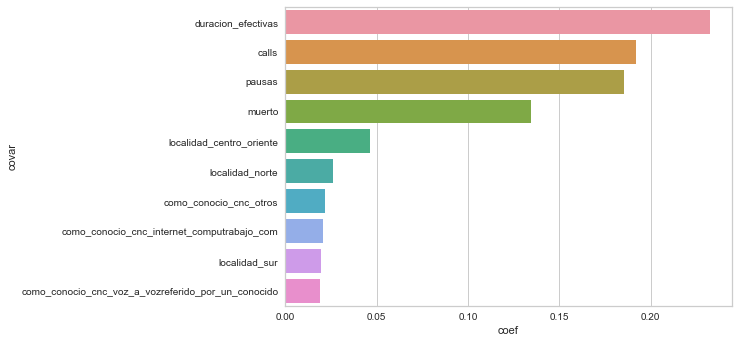

In [28]:
ps_score_forest, model_random=train_random_forest(X_train_sig,y_train,200,X_test_sig)
evaluate_model(model_random,y_test,ps_score_forest,cols_sig,10)

# KMEANS

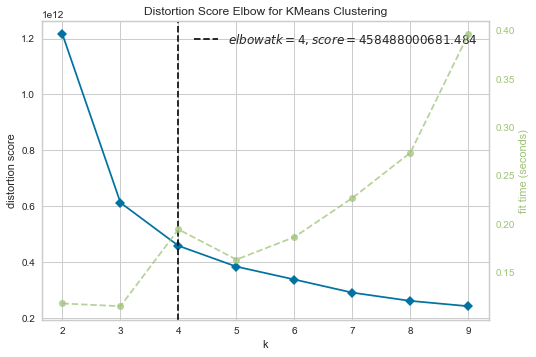

In [29]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(df_dummies)        # Fit the data to the visualizer
visualizer.show()    

In [30]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)

In [31]:
k_means.fit(df_dummies.drop('efectividad', axis=1))

KMeans(n_clusters=4, n_init=12)

In [32]:
k_means.labels_

array([1, 0, 3, 2, 1, 3, 2, 0, 2, 0, 0, 3, 2, 1, 3, 0, 1, 3, 2, 3, 0, 2,
       3, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 3, 2, 3, 2, 3, 1, 0, 1, 2, 2, 2,
       1, 2, 3, 1, 0, 2, 2, 3, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0,
       3, 2, 1, 0, 1, 3, 0, 3, 0, 0, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 3, 2,
       3, 0, 2, 0, 0, 3, 2, 0, 0, 1, 3, 1, 1, 3, 2, 3, 1, 2, 1, 2, 3, 3,
       1, 1, 2, 1, 1, 3, 1, 1, 3, 3, 0, 3, 1, 1, 2, 1, 3, 0, 3, 1, 2, 3,
       1, 0, 2, 3, 3, 2, 1, 0, 2, 1, 0, 3, 2, 0, 3, 1, 0, 0, 2, 2, 3, 3,
       2, 0, 2, 2, 1, 3, 3, 3, 1, 3, 1, 1, 3, 2, 1, 3, 2, 1], dtype=int32)

In [33]:
df_dummies['class_k-means']=k_means.labels_

In [34]:
g1=df_dummies[df_dummies['class_k-means']==0]
g2=df_dummies[df_dummies['class_k-means']==1]
g3=df_dummies[df_dummies['class_k-means']==2]
g4=df_dummies[df_dummies['class_k-means']==3]

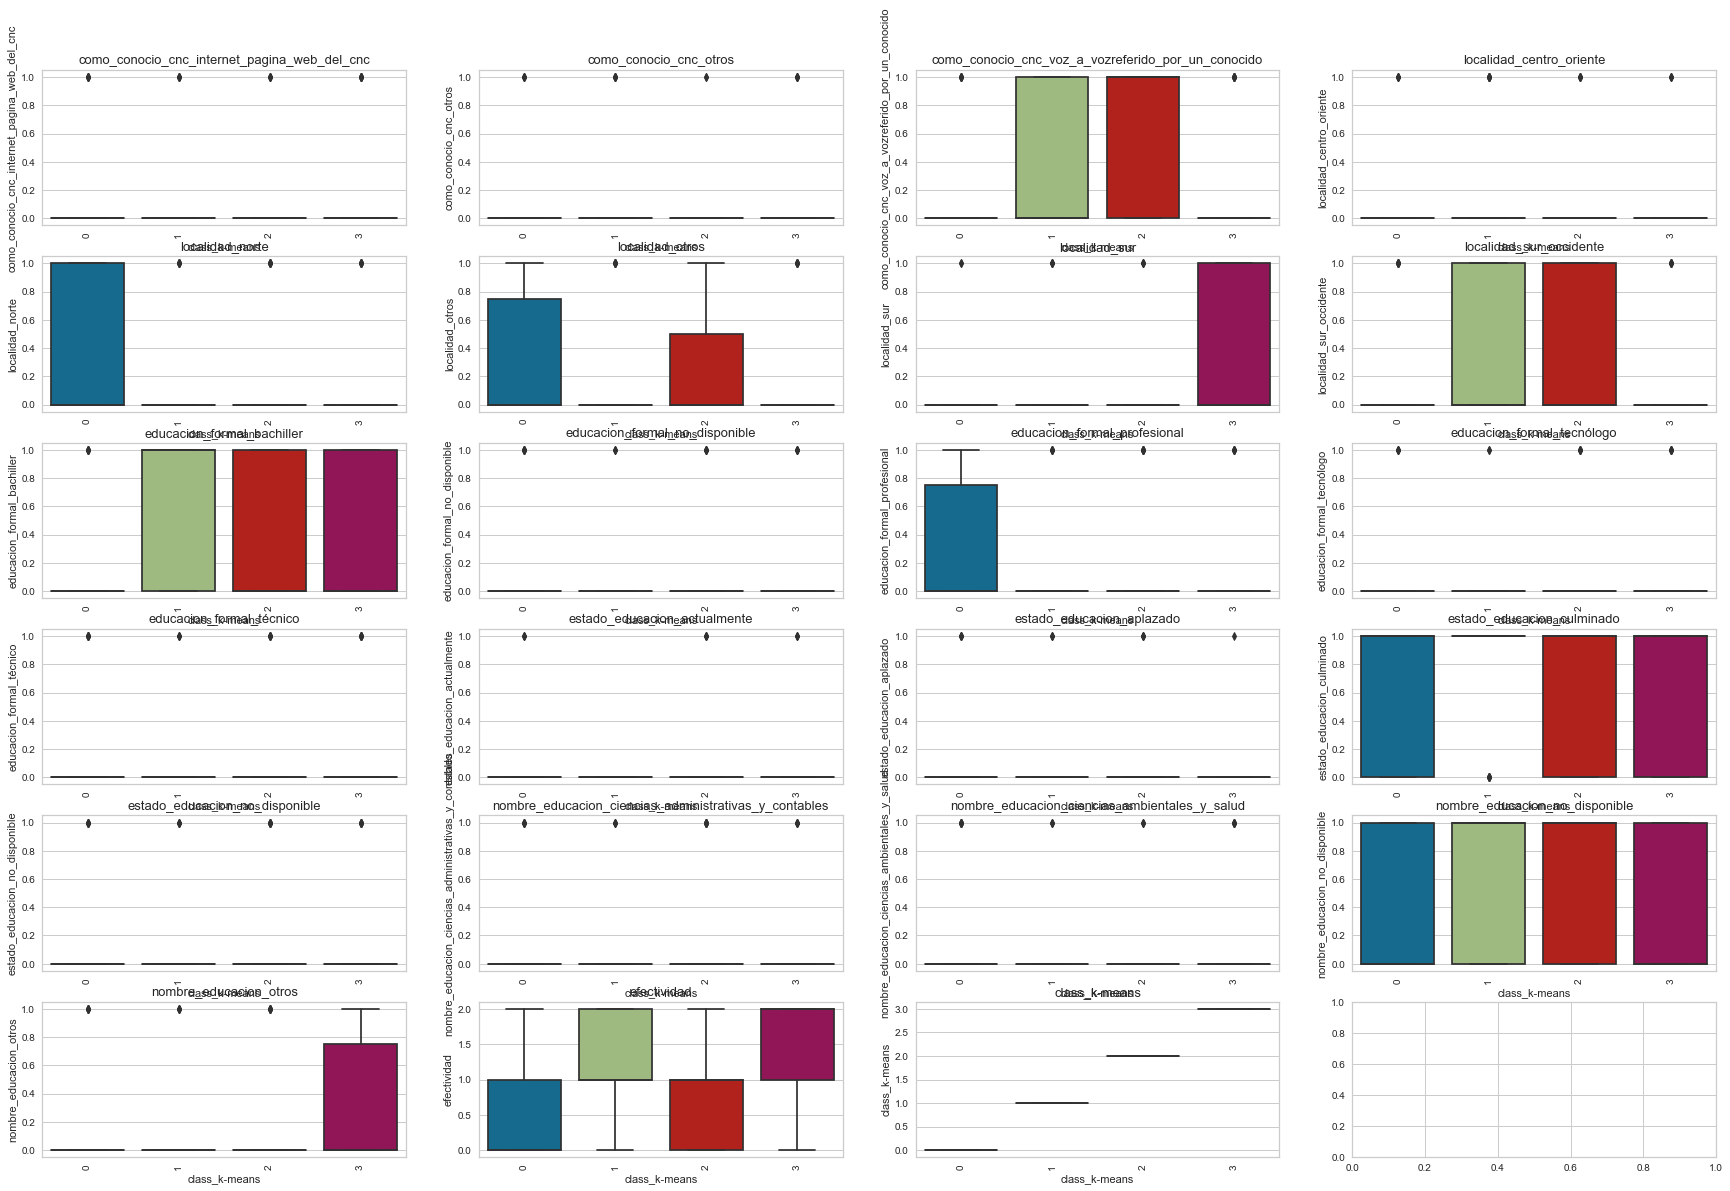

In [35]:
ig, ax = plt.subplots(ncols=4, nrows=6,figsize=(30,20))
for col, axis in zip(df_dummies.columns.tolist()[49:72], ax.flatten()):    
    ax_ = sns.boxplot(x='class_k-means', y=col, data=df_dummies, ax=axis)
    axis.set_title(col, fontsize=13) 
    axis.tick_params(axis="x",rotation=90, labelsize=10)

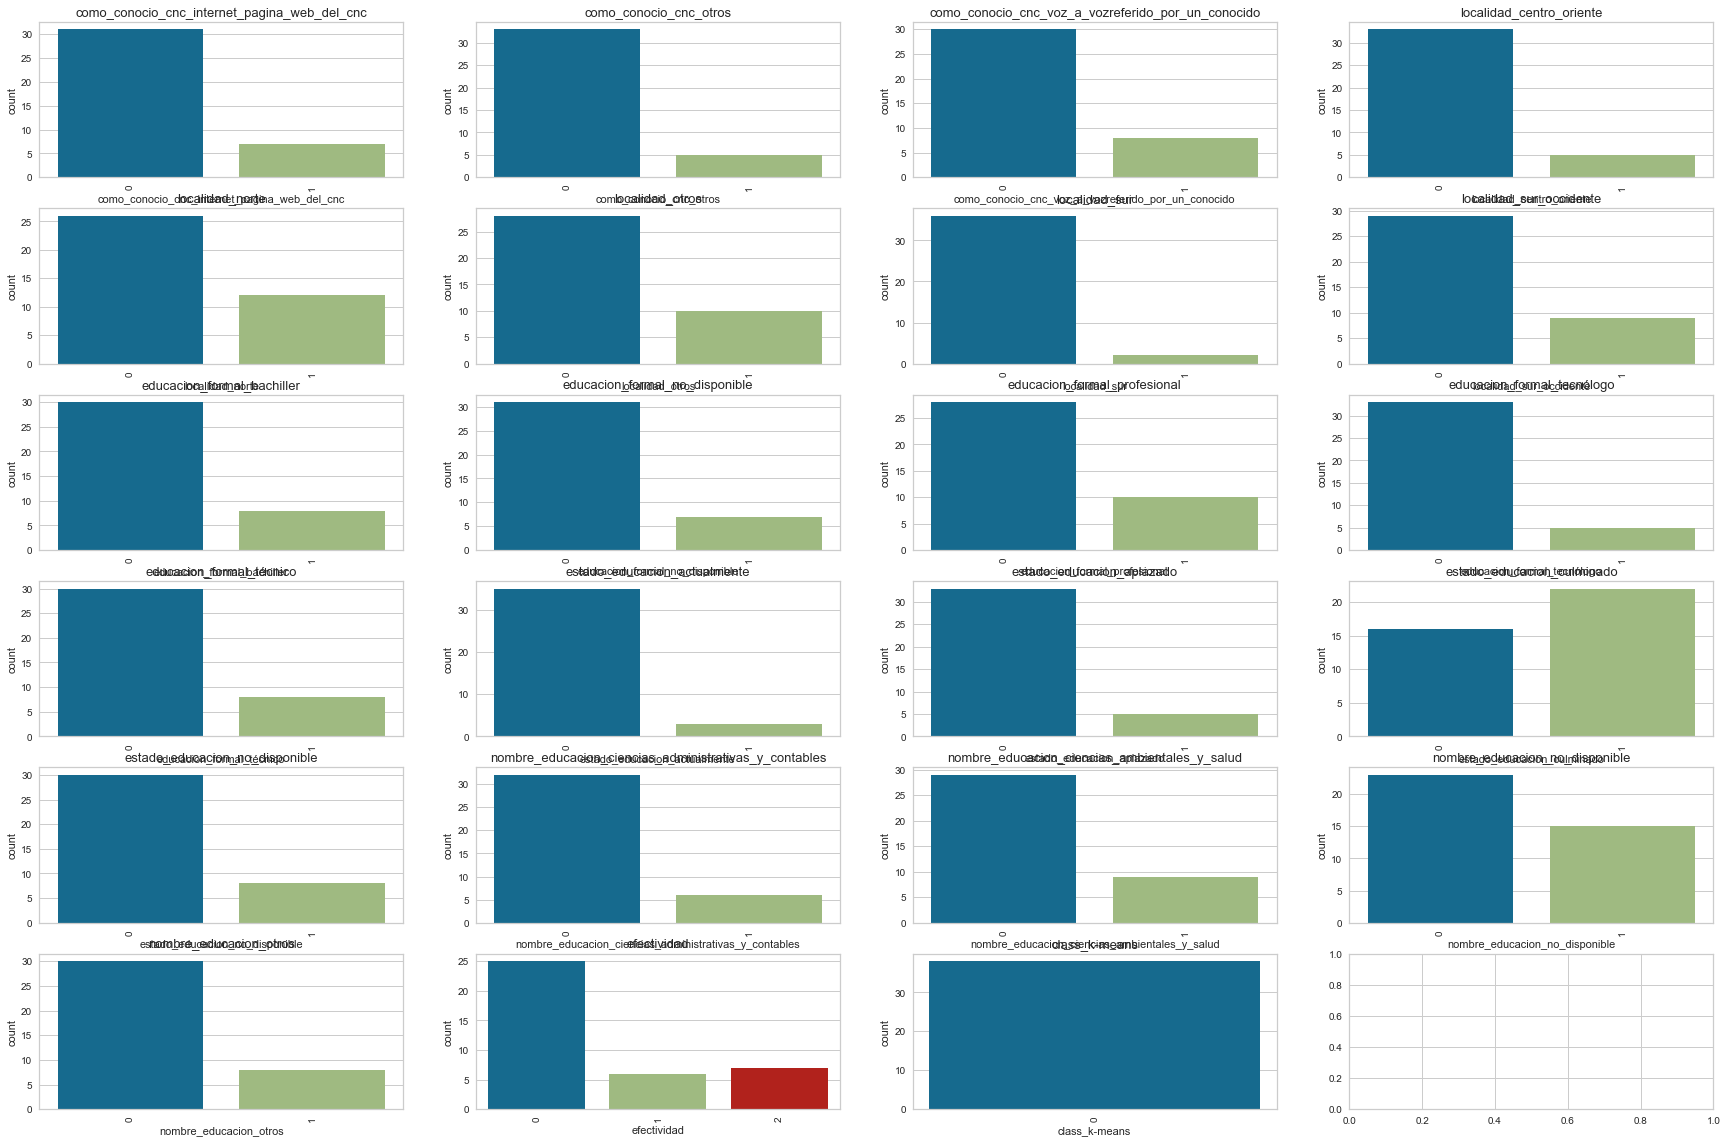

In [36]:
fig, ax = plt.subplots(ncols=4, nrows=6,figsize=(30,20))
for col, axis in zip(g1.columns.tolist()[49:72], ax.flatten()):    
    t=g1.groupby(col)[['calls']].count().rename(columns={'calls':'count'})
    ax_ = sns.barplot(x=t.index, y='count', data=t, ax=axis)
    axis.set_title(col, fontsize=13) 
    axis.tick_params(axis="x",rotation=90, labelsize=10)

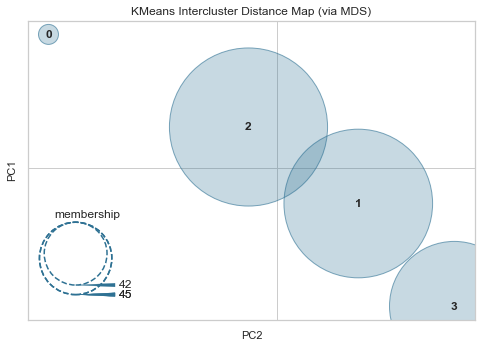

In [37]:
model = KMeans(4)
visualizer = InterclusterDistance(model)

visualizer.fit(df_dummies)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


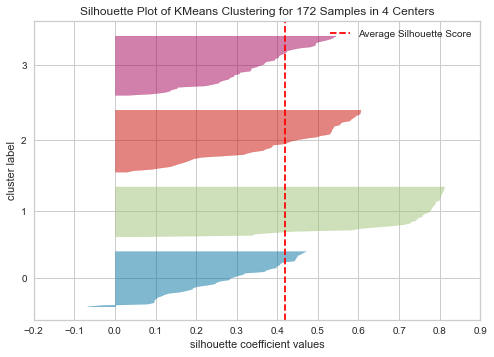

In [38]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df_dummies)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Segunda versión KMEANS

In [13]:
df_model2 = df1.copy()
df_model2.columns

Index(['codenc', 'calls', 'total', 'espera', 'hablado', 'disponible', 'pausas',
       'muerto', 'duracion_efectivas', 'dias_trabajados',
       'efectividad_ajustada', 'efectivas_mujer', 'efectivas_hombre',
       'efectivas_alto', 'efectivas_medio_alto', 'efectivas_medio_medio',
       'efectivas_bajo', 'efectivas_medio_bajo', 'efectivas_tunja',
       'efectivas_popayán', 'efectivas_montería', 'efectivas_manizales',
       'efectivas_armenia', 'efectivas_villavicencio', 'efectivas_pasto',
       'efectivas_cúcuta', 'efectivas_santa_marta', 'efectivas_ibagué',
       'efectivas_neiva', 'efectivas_pereira', 'efectivas_cartagena',
       'efectivas_cali', 'efectivas_bucaramanga', 'efectivas_barranquilla',
       'efectivas_medellín', 'efectivas_bogotá', 'efectivas_rango_edad_5',
       'efectivas_rango_edad_2', 'efectivas_rango_edad_4',
       'efectivas_rango_edad_3', 'efectivas_rango_edad_1', 'meses_trabajados',
       'competencias_funcionales', 'numeros', 'lectura_voz_alta',
      

In [210]:
#df_model.iloc[:,1:50].dtypes
#df_num = df_model.iloc[:,1:50]

df_num = df1[['calls', 'total', 'espera', 'hablado', 'disponible', 'pausas',
       'muerto', 'duracion_efectivas', 'efectividad_ajustada', 'efectivas_mujer', 'efectivas_hombre',
       'efectivas_alto', 'efectivas_medio_alto', 'efectivas_medio_medio',
       'efectivas_bajo', 'efectivas_medio_bajo', 'efectivas_rango_edad_5',
       'efectivas_rango_edad_2', 'efectivas_rango_edad_4',
       'efectivas_rango_edad_3', 'efectivas_rango_edad_1', 'meses_trabajados']]

print(df_num.shape)
df_num.head()

(172, 22)


calls          total         espera        hablado    disponible  \
0   6252.705882  623484.000000  150572.000000  313690.000000  42598.000000   
1  10989.000000  147804.000000   40859.500000   61113.500000  14951.500000   
2   6900.927106  820764.181818  235728.090909  330865.454545  88244.272727   
3   6440.057143  510847.500000  180869.500000  202350.000000  30753.500000   
4   6828.463768  613878.000000  160398.250000  247391.750000  64383.000000   

          pausas        muerto  duracion_efectivas  efectividad_ajustada  \
0  116624.000000   2193.000000         1102.323944           1804.235294   
1   30879.500000    289.000000          954.035714           1188.000000   
2  165926.363636   7262.818182          739.523805           2980.843057   
3   96874.500000   5939.500000          749.815857           1627.714286   
4  141705.000000  24955.500000          851.769881           1814.086957   

   efectivas_mujer  ...  efectivas_medio_alto  efectivas_medio_medio  \
0      1041.882353  ...            203.294118             279.529412   
1       216.000000  ...              0.000000               0.000000   
2      1365.456771  ...            215.046899             366.949085   
3       837.771429  ...            158.914286             222.171429   
4       690.521739  ...            188.347826             127.043478   

   efectivas_bajo  efectivas_medio_bajo  efectivas_rango_edad_5  \
0      838.588235            304.941176              406.588235   
1      324.000000            108.000000              216.000000   
2     1266.635006            663.479686              413.581327   
3      698.914286            408.857143              317.828571   
4      610.956522            369.913043              300.521739   

   efectivas_rango_edad_2  efectivas_rango_edad_4  efectivas_rango_edad_3  \
0              279.529412              279.529412              355.764706   
1              108.000000                0.000000                0.000000   
2              408.362482              514.200154              616.825489   
3              388.800000              274.628571              285.428571   
4              196.695652              214.434783              281.478261   

   efectivas_rango_edad_1  meses_trabajados  
0              482.823529                 1  
1              108.000000                 2  
2              807.946331                11  
3              361.028571                 2  
4              323.217391                 4  

[5 rows x 22 columns]

In [211]:
# Standardize the data to have a mean of ~0 and a variance of 1
mt_std = StandardScaler().fit_transform(df_num)
mt_std.shape

(172, 22)

In [212]:
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 20)
k_means.fit(mt_std)
df_model2['Cluster'] = k_means.labels_
df_model2['Cluster'].value_counts()

1    92
0    43
2    37
Name: Cluster, dtype: int64

In [213]:
#df_model2.groupby(['Cluster', 'como_conocio_cnc', 'educacion_formal', 'estado_educacion']).agg({'calls': 'mean', 'total': 'mean', 'duracion_efectivas': 'mean', 'efectividad_ajustada': 'mean'}) 
pd.crosstab(df_model2['Cluster'], df_model2['educacion_formal'])

educacion_formal  bachiller  no_disponible  profesional  tecnólogo  técnico
Cluster                                                                    
0                         9              5           11          7       11
1                        47             11           13          9       12
2                        15              5            8          4        5

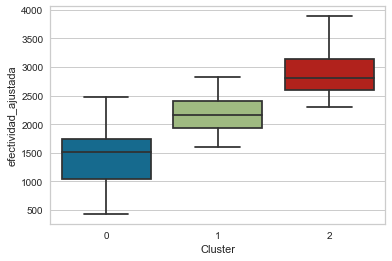

In [214]:
plt.figure(figsize=(6,4))
sns.boxplot(y='efectividad_ajustada', x='Cluster', data= df_model2)
plt.show()

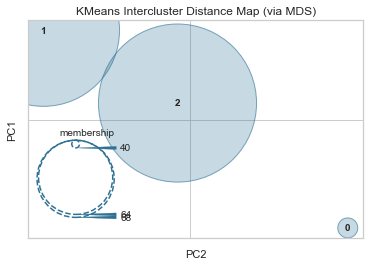

In [217]:
# Instantiate the clustering model and visualizer
model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(df_num)        # Fit the data to the visualizer
visualizer.show()  
